In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

from weak_sauce.movers import UniformIlluminationMover
from weak_sauce.fit_flat import FlatFitter
from weak_sauce.sources import Source
from weak_sauce.grid import MoveableGrid

In [3]:
hdulist = fits.open('../data/masterFlat.fits.fz') #not in repo--need to put in local install's data dir

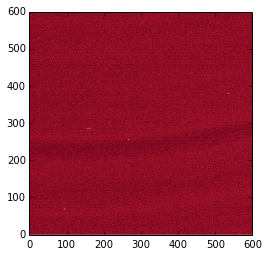

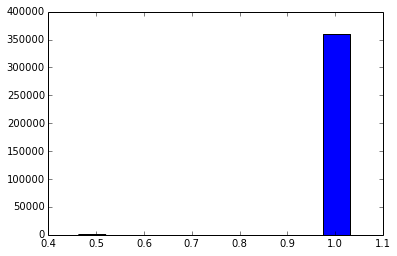

In [33]:
img = hdulist[1].data[700:1300,1100:1700]
img = img/np.mean(img)
#[low,high] = zscale.zscale(img)
plt.imshow(img)#,vmin=low,vmax=high)
plt.figure()
_ = plt.hist(img.flatten())
data_rel_flux_map = img

99999


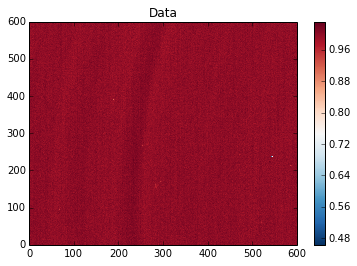

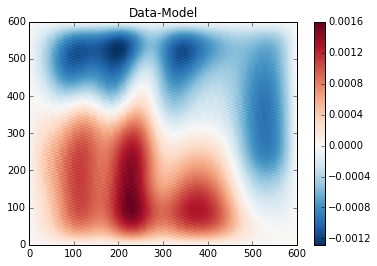

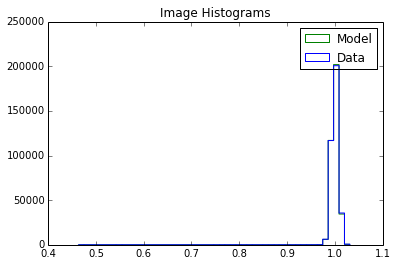

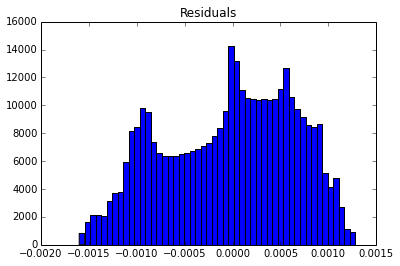

In [36]:
data_like_mover = UniformIlluminationMover()
data_like_source = Source(num_x=data_rel_flux_map.shape[0] + 1) 
data_like_source.fluxes += 1 #fit to flat field
data_mg = MoveableGrid(data_like_source,data_like_mover)
fitter = FlatFitter(data_rel_flux_map, luminosity=1)
oldlnlike = -10000
lnlike = -10000
for stepnum in xrange(100000):
    fitter(data_mg.source, step_size=1e-2)
    lnlike, oldlnlike = fitter.lnlike(data_mg.source.vertices, data_mg.source.fluxes), lnlike
    if lnlike < oldlnlike:
        break
print(stepnum)


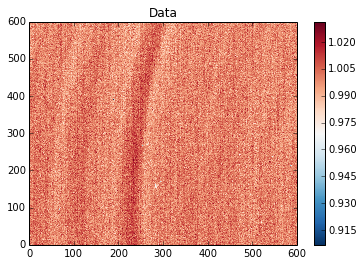

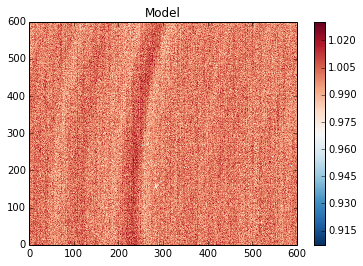

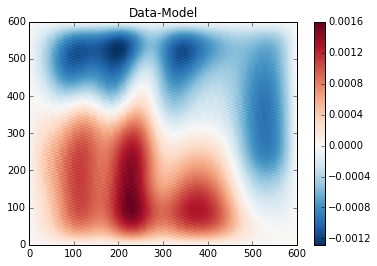

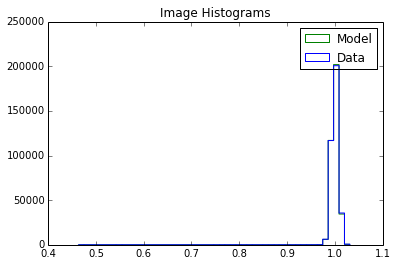

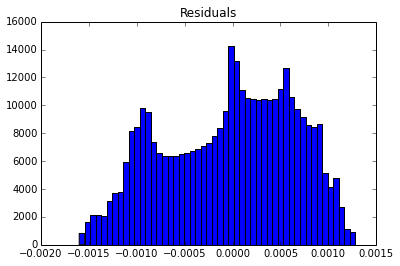

In [46]:
ZZ = np.ma.array(data_rel_flux_map.copy())
ZZ.mask = False * np.ones(ZZ.shape)
ZZ.mask[ZZ < 0.9] = True
data_mg.source.plot(ZZ, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data')

ZZ = np.ma.array(data_mg.source.fluxes.copy())
ZZ.mask = False * np.ones(ZZ.shape)
ZZ.mask[ZZ < 0.9] = True
data_mg.source.plot(ZZ, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Model')

data_mg.source.plot(data_rel_flux_map - data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data-Model')

plt.figure()
plt.title('Image Histograms')
_ = plt.hist([data_rel_flux_map.flatten(), data_mg.source.fluxes.flatten()],
             bins=50, histtype='step',label=['Data','Model'])
plt.legend()
plt.figure()
plt.title('Residuals')
_ = plt.hist((data_mg.source.fluxes - data_rel_flux_map).flatten(),bins=50)

(<matplotlib.figure.Figure at 0x113922290>,
 <matplotlib.axes.AxesSubplot at 0x113910b90>)

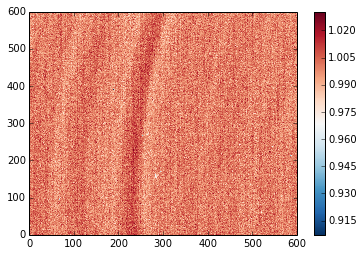

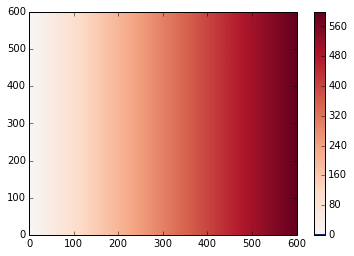

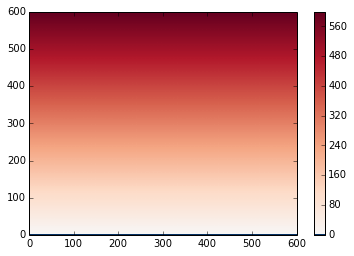

In [47]:
fig, ax = data_mg.source.plot(data_mg.source.vertices[:, :,0],
                              pcolormesh_kwargs_in={'linewidths':0})
fig, ax = data_mg.source.plot(data_mg.source.vertices[:, :,1],
                              pcolormesh_kwargs_in={'linewidths':0})

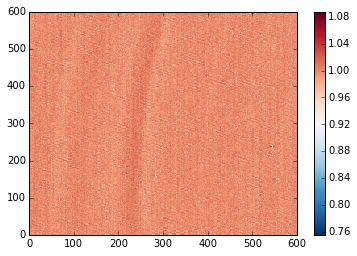

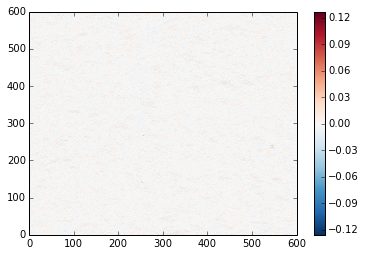

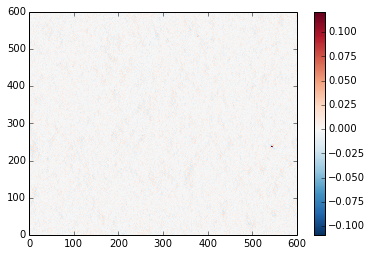

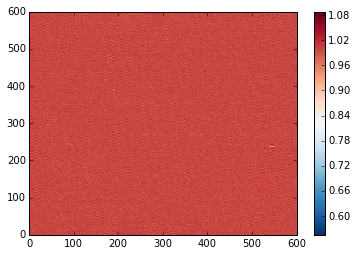

In [48]:
fig, ax = data_mg.source.plot(data_mg.source.vertices[1:, :,0] - 
                              data_mg.source.vertices[:-1, :,0],
                              pcolormesh_kwargs_in={'linewidths':0})
fig, ax = data_mg.source.plot(data_mg.source.vertices[:, 1:,0] - 
                              data_mg.source.vertices[:, :-1,0],
                              pcolormesh_kwargs_in={'linewidths':0})
fig, ax = data_mg.source.plot(data_mg.source.vertices[1:, :,1] - 
                              data_mg.source.vertices[:-1, :,1],
                              pcolormesh_kwargs_in={'linewidths':0})
fig, ax = data_mg.source.plot(data_mg.source.vertices[:, 1:,1] - 
                              data_mg.source.vertices[:, :-1,1],
                              pcolormesh_kwargs_in={'linewidths':0})

Hmm, this DES flat (no detrending, 4x larger than the LSST flat) doesn't fit very well at all... Possible explanations:

* According to the FITS header, the masterFlat is composed of only 10 coadded flats, so shot noise may be preventing the convergence of the model. However, if this were the case, we'd expect a speckled pattern in the residual, which we don't.

* Maybe it needs more steps to converge/smaller step size? Maybe, but improvement from 10k steps to 20k steps was marginal...

[[  99.9   99.8  100.    99.8   99.9]
 [  99.8  100.    99.9  100.    99.8]
 [ 100.    99.9  100.    99.9  100. ]
 [  99.8  100.    99.9  100.    99.8]
 [  99.9   99.8  100.    99.8   99.9]]


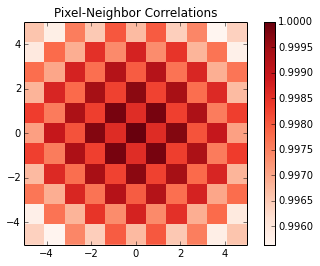

In [49]:
from weak_sauce.data_tools import makeCorr
_ = makeCorr(data_rel_flux_map - data_mg.source.fluxes, rescale_cmap=False)

[[  11.8   12.3   13.2   11.7   11.5]
 [  11.2   17.5   28.6   16.8   10.8]
 [  18.3   37.   100.    37.    18.3]
 [  10.8   16.8   28.6   17.5   11.2]
 [  11.5   11.7   13.2   12.3   11.8]]


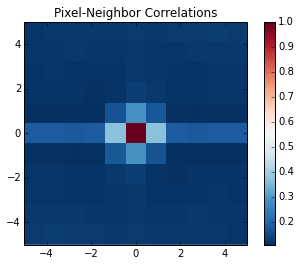

In [141]:
B = makeCorr(data_rel_flux_map, N=5, rescale_cmap=False)

[[   9.9   10.5   11.4    9.8    9.6]
 [   9.4   15.8   27.1   15.     8.9]
 [  16.6   35.7  100.    35.7   16.6]
 [   8.9   15.    27.1   15.8    9.4]
 [   9.6    9.8   11.4   10.5    9.9]]


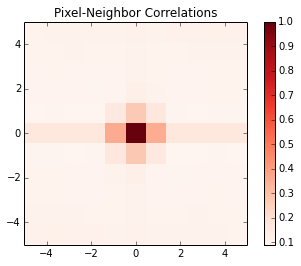

In [51]:
A = makeCorr(data_mg.source.fluxes, rescale_cmap=False)

<matplotlib.colorbar.Colorbar instance at 0x11a689f80>

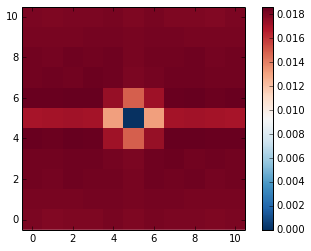

In [52]:
plt.imshow(B - A)
plt.colorbar()

The DES flat has very different correlation structure: TBC...

### Shape measurements of gaussians

In [82]:
verts = data_mg.source.vertices.copy()
simple_verts = np.dstack(np.meshgrid(
    np.linspace(0, verts.shape[0]-1, verts.shape[0], endpoint=True),
    np.linspace(0, verts.shape[1]-1, verts.shape[1], endpoint=True),
    indexing='ij'))
print(verts.shape, simple_verts.shape)

(601, 601, 2) (601, 601, 2)


In [86]:
np.random.randint(verts.shape[0]-1)

372

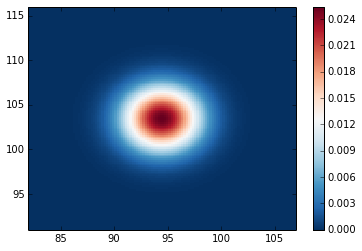

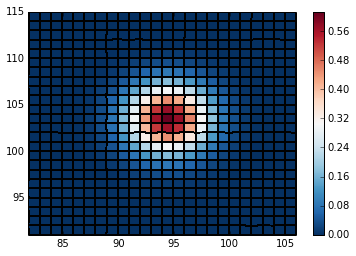

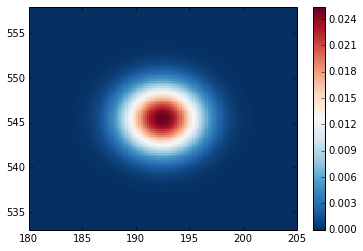

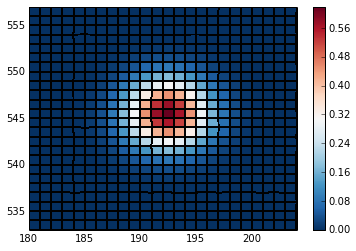

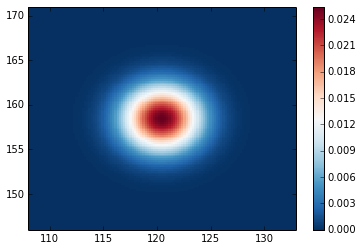

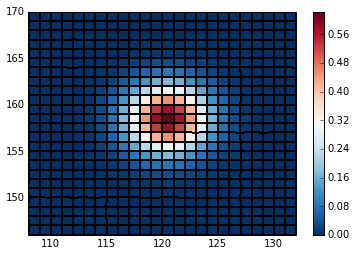

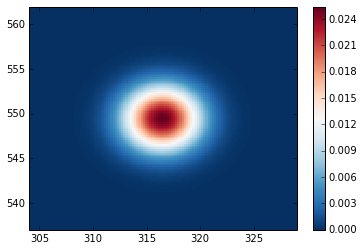

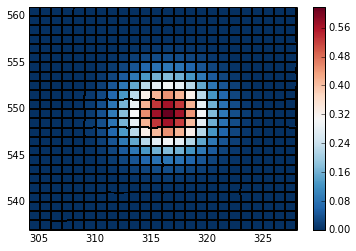

In [136]:
from weak_sauce.grid import MoveableGrid
from weak_sauce.movers import FixedIlluminationMover
# make an input source
def gauss(centroids, mu=np.array([0, 0]), sigma=np.array([1., 1.])):
    return np.exp(-0.5 * np.sum(np.square((centroids - mu) / sigma), axis=2)) / \
           (2 * np.pi * np.prod(sigma))
dlist = ['Mx', 'My', 'e0', 'e1', 'e2']
num_x = 25

for i in xrange(1,5):
    start_x = np.random.randint(verts.shape[0] - 1 - num_x)
    start_y = np.random.randint(verts.shape[1] - 1 - num_x)
#     print(start_x, start_y)

    mu = np.array([start_x + 0.5 * num_x, start_y + 0.5 * num_x])
    sigma = np.array([num_x * 0.1] * 2)

    stationary_source = Source(num_x=num_x*5, min_x=start_x, max_x=start_x + num_x, 
                               num_y=num_x*5, min_y=start_y, max_y=start_y + num_x,
                               flux_func=gauss, mu=mu, sigma=sigma)

    mover_fixed = FixedIlluminationMover(stationary_source)

    source_cutout = Source(num_x=num_x)  # pixel coordinates to match with stationary_souce
    source_cutout.vertices = verts[start_x:start_x + num_x, start_y:start_y + num_x].copy()


    mg = MoveableGrid(source_cutout, mover_fixed)

    mg.step()
    
    stationary_source.plot(stationary_source.fluxes,
                           stationary_source.vertices[:,:,0],
                           stationary_source.vertices[:,:,1],
                           pcolormesh_kwargs_in={'linewidths':0})
    source_cutout.plot(source_cutout.fluxes,
                       source_cutout.vertices[:,:,0],
                       source_cutout.vertices[:,:,1],
                       pcolormesh_kwargs_in={'linewidths':0.5})

    psf = mg.evaluate_psf()[dlist]
#     psf['dx'] = psf['Mx'] - mu[0] + (start_x)
#     psf['dy'] = psf['My'] - mu[1] + (start_y)
    psf['x_corner'] = start_x
    psf['y_corner'] = start_y
    
    
    # redo for a common grid
    if i == 0:
        # should ONLY need to do this once for a single gaussian
        source_cutout.vertices = simple_verts[start_x:start_x + num_x, start_y:start_y + num_x].copy()
        mg = MoveableGrid(source_cutout, mover_fixed)
        mg.step()
        psf2 = mg.evaluate_psf()[dlist]
        #psfs = psf2

    for di in dlist:
        psf['d{0}'.format(di)] = psf[di] - psf2[di]
    
    psfs = psfs.append(psf, ignore_index=True)
# psfs

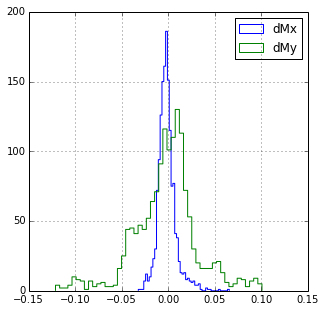

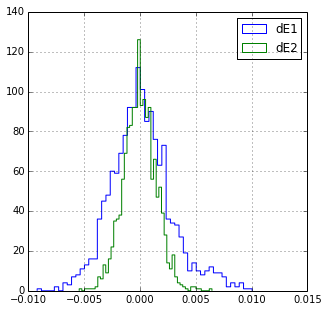

In [156]:
# now show a distribution of the d's
binnum = 50
for di in dlist + ['E', 'M']:
    key = 'd{0}'.format(di)
    if di == 'M':
        dmx = psfs['dMx']
        dmy = psfs['dMy']
        df = pd.DataFrame({'dMx': dmx, 'dMy': dmy})
        df['dMx'].hist(bins=binnum, histtype='step', figsize=(5,5), label='dMx')
        df['dMy'].hist(bins=binnum, histtype='step', label='dMy')
        plt.legend()
plt.figure()
for di in dlist + ['E', 'M']:
    key = 'd{0}'.format(di)
    if di == 'E':
        de1 = (psfs['e1'] / psfs['e0'] - (psf2['e1'] / psf2['e0']).values).values
        de2 = (psfs['e2'] / psfs['e0'] - (psf2['e2'] / psf2['e0']).values).values
        df = pd.DataFrame({'dE1': de1, 'dE2': de2})
        df['dE1'].hist(bins=binnum, histtype='step', figsize=(5,5), label='dE1')
        df['dE2'].hist(bins=binnum, histtype='step', label='dE2')
        plt.legend()
    else:
        pass
        #psfs[key].hist(bins=binnum, histtype='step')
    #plt.title(key)

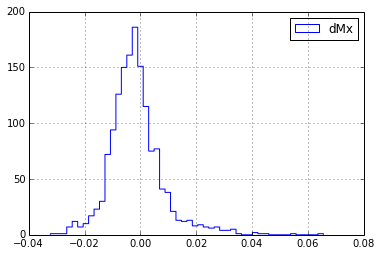

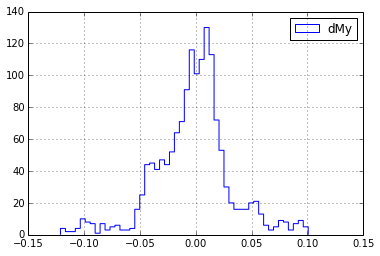

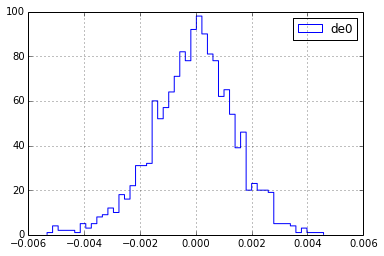

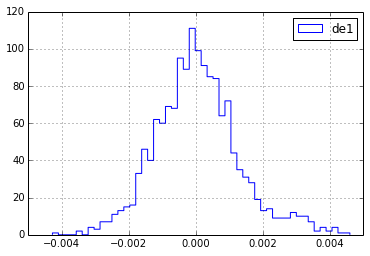

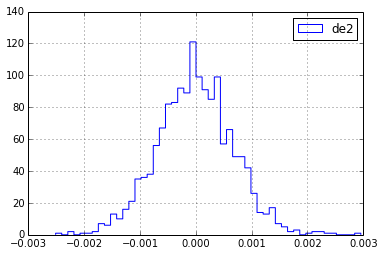

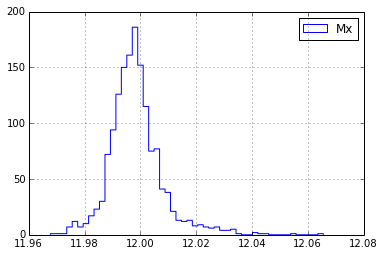

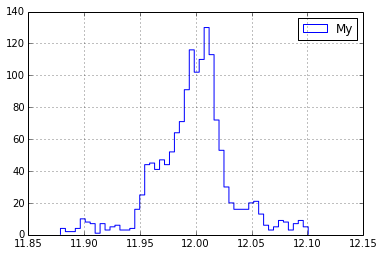

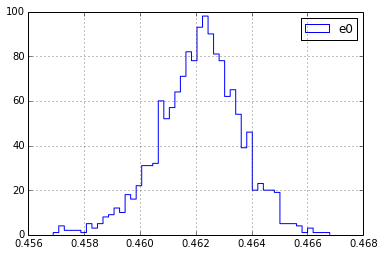

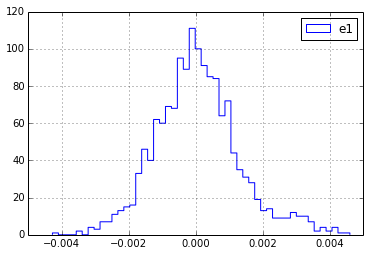

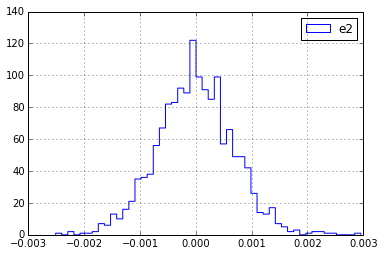

In [172]:
for di in dlist:
    plt.figure()
    key = 'd{0}'.format(di)
    psfs[key].hist(bins=binnum, histtype='step', label=key)
    plt.legend()
for di in dlist:
    plt.figure()
    key = '{0}'.format(di)
    psfs[key].hist(bins=binnum, histtype='step', label=key)
    plt.legend()

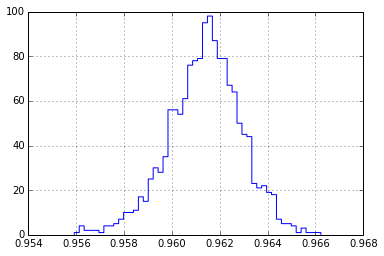

In [170]:
(np. sqrt(2*psfs['e0'])).hist(bins=binnum, histtype='step')